<b>Class Activation Map</b>



<b>References:</b><br/>
<a href="https://alexisbcook.github.io/2017/global-average-pooling-layers-for-object-localization/">Global Average Pooling Layers for Object Localization, Alexis Cook</a> 

https://towardsdatascience.com/multi-label-classification-and-class-activation-map-on-fashion-mnist-1454f09f5925

https://www.kaggle.com/ernie55ernie/mnist-with-keras-visualization-and-saliency-map

https://github.com/metalbubble/CAM/blob/master/pytorch_CAM.py
http://snappishproductions.com/blog/2018/01/03/class-activation-mapping-in-pytorch.html

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import os

import torch
from torch import optim
from torchvision import  transforms

from sklearn.model_selection import ParameterGrid

from lib.classifier import *
from lib.utils import *
from lib.models import LeNet_5_AVG
from lib.task import load_data

%load_ext watermark
%watermark -a "tb" -d -v -m -p sys,numpy,pandas,sklearn,torch,IPython
gpu_stat()

tb 2018-09-25 

CPython 3.6.4
IPython 6.2.1

sys 3.6.4 |Anaconda custom (64-bit)| (default, Jan 16 2018, 12:04:33) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
numpy 1.14.2
pandas 0.22.0
sklearn 0.19.2
torch 0.4.0a0+9692519
IPython 6.2.1

compiler   : GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 17.5.0
machine    : x86_64
processor  : i386
CPU cores  : 24
interpreter: 64bit

GPU Name: TITAN Xp
GPU Memory: 12.0GB
CUDA Version: (9, 1, 0)
GPU Free/Total Memory: 61%


In [2]:
#torch.cuda.is_available = lambda : False
#torch.backends.cudnn.enabled=False
torch.backends.cudnn.deterministic = True

In [3]:
SEED=0
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

In [8]:
class MINIST_Net4(nn.Module):
    def __init__(self, D_in=(1,28,28), H=256, D_out=10, dropout=0.25, initialize=None):
        super(MINIST_Net4, self).__init__()
        self.D_in = D_in
        self.H = H
        self.D_out = D_out
        self.droput = dropout
        self.initialize = initialize

        self.conv1 = nn.Sequential(
            nn.Conv2d(D_in[0], 32, kernel_size=(5,5), bias=False),
            nn.BatchNorm2d(32, affine=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=(5,5), bias=False),
            nn.BatchNorm2d(32, affine=True),
            nn.MaxPool2d(2, 2),
            nn.ReLU(inplace=True)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=(3,3), bias=False),
            nn.BatchNorm2d(64, affine=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=(3,3), bias=False),
            nn.BatchNorm2d(64, affine=True),
            nn.MaxPool2d(2, 2),
            nn.ReLU(inplace=True)
        )

        self.conv3 = nn.Sequential(
            nn.Dropout(dropout),
            nn.Conv2d(64, H, kernel_size=(1,1), bias=False),
            nn.BatchNorm2d(H, affine=True),
            nn.ReLU(inplace=True),
        )
        
        self.avgpool = nn.AvgPool2d(kernel_size=3, stride=1)
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        if not self.initialize is None:
            self.initialize(self)

    def forward(self, x):
        x = x.view(-1, self.D_in[0], self.D_in[1], self.D_in[2])
        
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        
        x = self.avgpool(x)
        
        x = x.view(-1, self.H * 1 * 1)
        x = self.classifier(x)

        return x

In [9]:
model = MINIST_Net4(D_in=(1,28,28), D_out=10, H=128, dropout=0.25, initialize=None)
_ = model.load_state_dict(torch.load('./LeNet_NET2_model.tar'))

In [10]:
class ToNumpy(object):
    def __call__(self, arr):
        return np.array(arr)
    def __repr__(self):
        return self.__class__.__name__ + '()'

class ToItem(object):
    def __call__(self, val):
        return val.item()
    def __repr__(self):
        return self.__class__.__name__ + '()'
    
image_transform = transforms.Compose([
        ToNumpy()
    ])

target_transform = transforms.Compose([
        ToItem()
    ])

dataset = list(MNIST('./data', dataset="train", download=True, 
                     transform=image_transform, target_transform=target_transform))

X_train, y_train = zip(*dataset)
X_train, y_train = np.array(X_train), np.array(y_train)

In [11]:
class FeatureActivations():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = ((output.cpu()).data).numpy()
    def remove(self): self.hook.remove()

In [12]:
import cv2

def create_heatmap(feature_conv, weight_softmax, class_idx):
    # generate the class activation maps 
    size_upsample = (28, 28)
    bz, nc, h, w = feature_conv.shape
    output_cam = []
    for idx in class_idx:
        cam = weight_softmax[class_idx].dot(feature_conv.reshape((nc, h*w)))
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        cam_img = cv2.resize(cam_img, size_upsample)
        output_cam.append(cam_img)
    return output_cam

In [13]:
def predict(model, img_batch):
    model.eval()
    with torch.no_grad():
        y_pred = []
        inputs = torch.from_numpy(img_batch).float()
        inputs = Variable(inputs)

        outputs = model(inputs)

        out = torch.max(outputs, 1)[1]
        y_pred = out.data.cpu().numpy()
    return y_pred

<IPython.core.display.Javascript object>


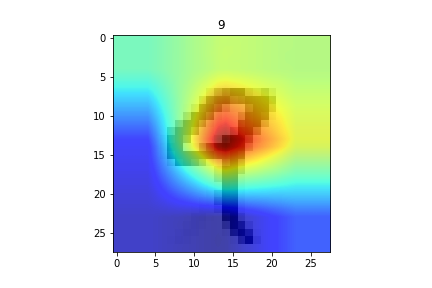

interactive(children=(IntSlider(value=4, description='char', max=9), IntSlider(value=50, description='idx'), IntSlider(value=4, description='cl', max=9), Output()), _dom_classes=('widget-interact',))

In [14]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.ion()

img = X_train[0]
# im = plt.imshow(img.reshape(28,28), cmap='jet')
plt.figure(facecolor='white')
@interact(char=(0,9), idx=(0,100), cl=(0,9))
def cam(char, idx, cl):

    label_idx = y_train == char
    img = X_train[label_idx][idx]
    label = y_train[label_idx][idx]

    img_batch = np.expand_dims(img, 0)

    final_layer = model._modules.get('conv3')
    activated_features = FeatureActivations(final_layer)

    y_pred = predict(model, img_batch)  

    activated_features.remove()

    weight_softmax_params = list(model._modules.get('classifier').parameters())
    weight_softmax = np.squeeze(weight_softmax_params[0].cpu().data.numpy())

    # normalize the image
    stacked_img = np.stack((img.reshape(28, 28),)*3, axis=2)
    stacked_img = stacked_img - np.min(stacked_img)
    stacked_img = stacked_img / np.max(stacked_img)
    stacked_img = np.uint8(255 * stacked_img)
    
    heatmap = create_heatmap(activated_features.features, weight_softmax, [cl ])

    plt.title(label)    
    plt.imshow(np.invert(stacked_img),alpha=0.8)
    plt.imshow(heatmap[0], alpha=0.7, cmap='jet', interpolation= 'bilinear')

In [ ]:
plt.ioff()